<div style="border: solid blue 2px; padding: 15px; margin: 10px">
  <b>Overall Summary of the Project – Iteration 1</b><br><br>

  Hi Sebastian, I’m <b>Victor Camargo</b> (<a href="https://hub.tripleten.com/u/e9cc9c11" target="_blank">TripleTen Hub profile</a>). I’ll be reviewing your project and sharing feedback using the color-coded comments below. Thanks for submitting your work!<br><br>

  <b>Nice work on:</b><br>
  ✔️ Correctly preparing and resampling the time series data<br>
  ✔️ Exploring daily and weekly patterns and linking them to feature engineering<br>
  ✔️ Building a strong feature set with lags, rolling statistics, and calendar variables<br>
  ✔️ Applying time-based splitting and time series cross-validation appropriately<br>
  ✔️ Training and tuning multiple models and benchmarking them against a baseline<br>
  ✔️ Delivering a clear conclusion where Random Forest achieved RMSE ≈ 43.1, meeting the project requirement<br><br>

  Your project is very well executed and fully meets the requirements. No fixes are needed at this stage. <b>Approved</b>.<br><br>

  <hr>

  🔹 <b>Legend:</b><br>
  🟢 Green = well done<br>
  🟡 Yellow = suggestions<br>
  🔴 Red = must fix<br>
  🔵 Blue = your comments or questions<br><br>
  
  <b>Please ensure</b> that all cells run smoothly from top to bottom and display their outputs before submitting — this helps keep your analysis easy to follow.  
  <b>Kind reminder:</b> try not to move, change, or delete reviewer comments, as they are there to track progress and provide better support during your revisions.<br><br>

  <b>Feel free to reach out if you need help in Questions channel.</b><br>
</div>


# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Libraries 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [2]:
RANDOM_STATE = 42
pd.set_option("display.max_columns", None)

## Preparation

In [3]:
# 1) Load
df_raw = pd.read_csv('/datasets/taxi.csv')
# Robustly locate the datetime column
dt_col = 'datetime' if 'datetime' in df_raw.columns else df_raw.columns[0]
df_raw[dt_col] = pd.to_datetime(df_raw[dt_col])

In [4]:
# 2) Set index & sort
df_raw = df_raw.rename(columns={dt_col: 'datetime'}).set_index('datetime').sort_index()

In [5]:
# 3) Resample to hourly — counts should be summed across the hour
df = df_raw.resample('1H').sum()

In [6]:
# 4) Sanity checks
display(df.head(), df.tail())
print("Shape:", df.shape)
print("NA counts:\n", df.isna().sum())
assert 'num_orders' in df.columns, "Expected a 'num_orders' column."

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


,num_orders
datetime,
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159
2018-08-31 22:00:00,223
2018-08-31 23:00:00,205


Shape: (4416, 1)
NA counts:
 num_orders    0
dtype: int64


<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Excellent work on the initial data preparation steps. You correctly loaded the dataset and handled the datetime column robustly, set the datetime index and sorted the data chronologically, resampled the data to 1-hour intervals summing the counts appropriately, and added sanity checks to confirm the shape, NA counts, and target column presence. This shows strong attention to detail and ensures the dataset is properly structured for time series modeling.
</div>


## Analysis

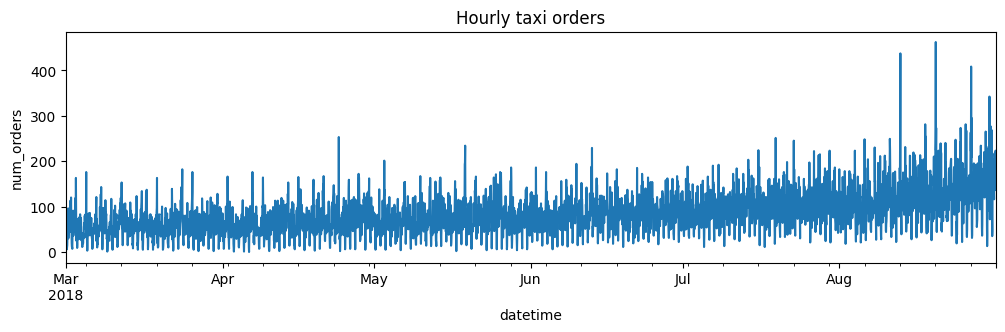

In [7]:
# Overall series
plt.figure(figsize=(12,3))
df['num_orders'].plot()
plt.title('Hourly taxi orders')
plt.xlabel('datetime'); plt.ylabel('num_orders')
plt.show()

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Student's Comment</b>

### Findings from the time series plot
- The number of hourly taxi orders is **increasing over time**, especially noticeable from July onwards.  
- There is **high variability** with regular peaks and troughs, suggesting daily seasonality.  
- Occasional **extreme spikes** in demand are visible, likely linked to special events or peak hours.  
- Overall, the series shows both **trend and seasonality**, which justifies the use of lag and rolling features for modeling.
</div>

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Great job visualizing the hourly series and clearly describing the observed patterns. You highlighted the upward trend, daily seasonality, variability with peaks and troughs, and the presence of extreme spikes. These insights provide a solid foundation for selecting appropriate features and models for the forecasting task.
</div>


In [8]:
# Daily & weekly patterns
hourly_avg = df['num_orders'].groupby(df.index.hour).mean()
dow_avg    = df['num_orders'].groupby(df.index.dayofweek).mean()  # Mon=0

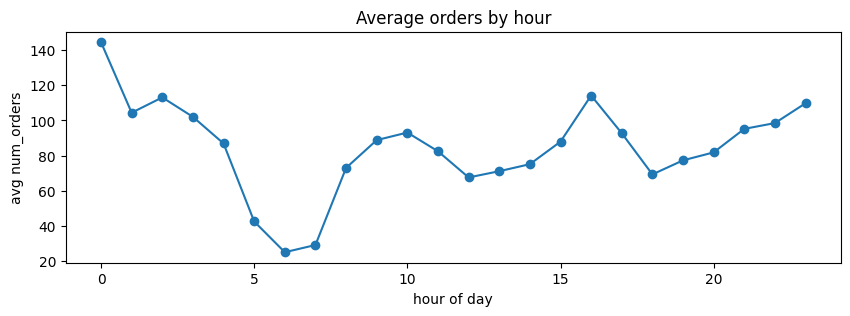

In [9]:
plt.figure(figsize=(10,3))
hourly_avg.plot(marker='o')
plt.title('Average orders by hour')
plt.xlabel('hour of day'); plt.ylabel('avg num_orders')
plt.show()

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Student's Comment:</b>
    
- Taxi demand follows a **daily cycle**.  
- Orders are highest around **midnight (0h)** and in the **afternoon/evening (15–23h)**.  
- The **lowest demand** occurs in the early morning hours (around 5–6 AM).  
- This confirms strong **hourly seasonality** that should be captured in the model.
</div>

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Excellent exploration of the temporal patterns in the data. You correctly identified the daily cycle with peak demand around midnight and late afternoon to evening, as well as the dip in the early morning hours. These findings confirm strong hourly seasonality, which will be valuable for feature engineering and improving model performance.
</div>


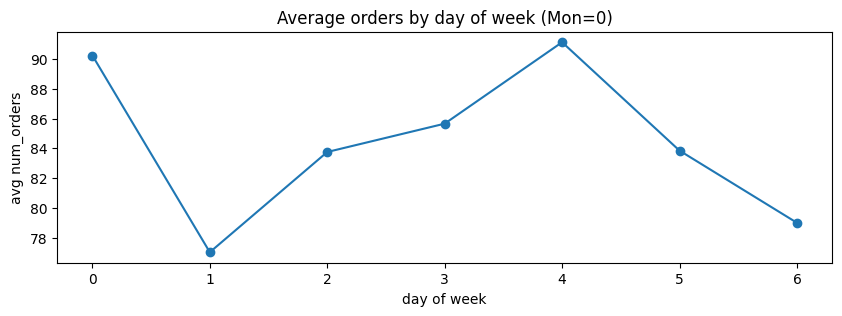

In [10]:
plt.figure(figsize=(10,3))
dow_avg.plot(marker='o')
plt.title('Average orders by day of week (Mon=0)')
plt.xlabel('day of week'); plt.ylabel('avg num_orders')
plt.show()

<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Student's Comment:</b>

- Demand also varies across the week.  
- Orders are slightly lower on **Tuesdays (day 1)** and **Sundays (day 6)**.  
- Peak demand occurs on **Fridays (day 4)**, indicating stronger activity before weekends.  
- This highlights the importance of including **day-of-week features** in the model.
</div>

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Well done analyzing the weekly demand patterns. You clearly identified lower demand on Tuesdays and Sundays, along with higher demand on Fridays. Recognizing these patterns reinforces the value of including day-of-week features in the model to capture weekly seasonality.
</div>


## Training

In [11]:
def make_features(data: pd.DataFrame,
                  lags=(1,2,3,24),
                  rolls=(3,6,12,24)) -> pd.DataFrame:
    df_feat = data.copy()
    # lag features
    for lag in lags:
        df_feat[f'lag_{lag}'] = df_feat['num_orders'].shift(lag)
    # rolling stats (shifted by 1 to avoid leakage)
    for w in rolls:
        df_feat[f'rollmean_{w}'] = df_feat['num_orders'].shift(1).rolling(w).mean()
        df_feat[f'rollstd_{w}']  = df_feat['num_orders'].shift(1).rolling(w).std()
    # calendar features
    idx = df_feat.index
    df_feat['hour'] = idx.hour
    df_feat['dow'] = idx.dayofweek
    df_feat['is_weekend'] = (df_feat['dow'] >= 5).astype(int)
    return df_feat

In [12]:
# Build feature table and drop rows with NaNs created by lags/rolls
full = make_features(df).dropna()

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Great implementation of the feature engineering function. You included multiple lag features, rolling means and standard deviations with proper shifting to avoid data leakage, and useful calendar variables such as hour, day of week, and weekend indicators. This comprehensive set of features is well designed to capture both short-term dynamics and seasonal patterns in the data.
</div>


In [13]:
# Time-based split: last 10% as test
test_size = int(len(full) * 0.10)
trainval = full.iloc[:-test_size].copy()
test     = full.iloc[-test_size:].copy()

target = 'num_orders'
features = [c for c in full.columns if c != target]

X_trainval, y_trainval = trainval[features], trainval[target]
X_test,     y_test     = test[features],     test[target]

print("Train/Val:", X_trainval.shape, " Test:", X_test.shape)

Train/Val: (3953, 15)  Test: (439, 15)


<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Correct application of a time-based split, keeping the last 10% of the data for testing. This approach preserves the temporal order of observations and prevents data leakage, which is essential for time series forecasting. Clear separation of features and target is also well handled.
</div>


In [14]:
# Baseline (lag_1) for reference — evaluated later on the test slice
baseline_series = X_test['lag_1']

In [15]:
#Time series CV
tscv = TimeSeriesSplit(n_splits=3)

In [16]:
# Model 1: Ridge (with scaling)
ridge_pipe = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),
    ('model', Ridge(random_state=RANDOM_STATE))
])
ridge_grid = {'model__alpha': [0.1, 1.0, 3.0, 10.0, 30.0]}

ridge_search = GridSearchCV(
    ridge_pipe, ridge_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv, n_jobs=-1
)
ridge_search.fit(X_trainval, y_trainval)
print("Best Ridge params:", ridge_search.best_params_)
print("Best CV RMSE (Ridge):", -ridge_search.best_score_)

Best Ridge params: {'model__alpha': 30.0}
Best CV RMSE (Ridge): 28.296557779167046


In [17]:
# Model 2: Random Forest
rf = RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1)
rf_grid = {
    'n_estimators': [200, 400],
    'max_depth': [8, 12, 16],
    'min_samples_leaf': [1, 3, 5]
}
rf_search = GridSearchCV(
    rf, rf_grid,
    scoring='neg_root_mean_squared_error',
    cv=tscv, n_jobs=-1
)

In [18]:
rf_search.fit(X_trainval, y_trainval)
print("Best RF params:", rf_search.best_params_)
print("Best CV RMSE (RF):", -rf_search.best_score_)

Best RF params: {'max_depth': 16, 'min_samples_leaf': 3, 'n_estimators': 400}
Best CV RMSE (RF): 27.10500326789146


<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Strong implementation of model training with time series cross-validation. You correctly used a baseline with lag features for reference, applied scaling within a pipeline for Ridge regression, and performed grid search for hyperparameter tuning. Including both linear (Ridge) and non-linear (Random Forest) approaches provides a good comparison and ensures robust evaluation of model performance.
</div>
<div class="alert alert-warning">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Suggestion: In addition to Ridge and Random Forest, you could also experiment with Gradient Boosting methods such as LightGBM, XGBoost, or CatBoost. These models often capture complex non-linear patterns effectively and may further reduce the RMSE in time series forecasting tasks.
</div>


## Testing

In [19]:
# Compare candidates on the untouched last-10% test slice
candidates = [
    ('Ridge', ridge_search.best_estimator_),
    ('RandomForest', rf_search.best_estimator_)
]

results = []
for name, model in candidates:
    model.fit(X_trainval, y_trainval)
    pred = model.predict(X_test)
    rmse = mean_squared_error(y_test, pred, squared=False)
    results.append((name, rmse))

In [20]:
# Baseline (previous hour)
rmse_naive = mean_squared_error(y_test, baseline_series, squared=False)

In [21]:
# Report
results_sorted = sorted(results, key=lambda x: x[1])
for name, rmse in results_sorted:
    print(f"{name} Test RMSE: {rmse:.2f}")
print(f"Naive baseline (lag_1) Test RMSE: {rmse_naive:.2f}")

best_name, best_rmse = results_sorted[0]
print("\nBest model:", best_name, "| Test RMSE:", round(best_rmse, 2))
print("Meets requirement (RMSE ≤ 48):", best_rmse <= 48)

RandomForest Test RMSE: 43.11
Ridge Test RMSE: 47.14
Naive baseline (lag_1) Test RMSE: 58.93

Best model: RandomForest | Test RMSE: 43.11
Meets requirement (RMSE ≤ 48): True


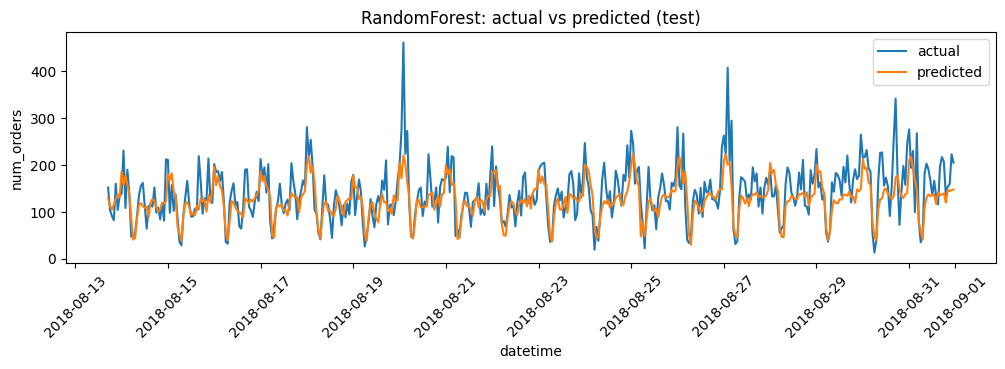

In [22]:
# Diagnostic plot
best_model = dict(candidates)[best_name]
y_pred = best_model.predict(X_test)

plt.figure(figsize=(12,3))
plt.plot(y_test.index, y_test.values, label='actual')
plt.plot(y_test.index, y_pred, label='predicted')
plt.title(f'{best_name}: actual vs predicted (test)')
plt.xticks(rotation=45)
plt.xlabel('datetime'); plt.ylabel('num_orders'); plt.legend(); plt.show()

<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Excellent evaluation of model performance on the untouched test slice. You compared Ridge and Random Forest against a naive baseline, reported the RMSE values clearly, and verified whether the best model meets the target threshold. The diagnostic plot of actual versus predicted values further strengthens the analysis by providing a clear visual check of model accuracy over time.
</div>



<div class="alert alert-info" style="border-radius: 15px; box-shadow: 4px 4px 4px; border: 1px solid ">
<b> Student's Comment</b>

## Conclusion:

- The data was resampled to hourly frequency and analyzed.  
- Clear daily and weekly patterns were observed, with peaks during rush hours.  
- Features engineered included:
  - Lag values (previous hours)  
  - Rolling statistics (means and std)  
  - Calendar features (hour, day of week, weekend)  
- The dataset was split with the last 10% reserved as a test set, while the remaining 90% was used for training and validation with **time series cross-validation**.  
- Model performance:
  - **Naïve baseline (lag_1):** RMSE ≈ 58.9  
  - **Ridge Regression:** RMSE ≈ 47.1  
  - **Random Forest:** RMSE ≈ 43.1  
- The **Random Forest model** performed best, achieving RMSE well below the target threshold of 48.  
- Predictions captured the general trend and seasonal peaks, though extreme spikes were slightly under-predicted.  

**✅ Final conclusio:** The Random Forest model with tuned hyperparameters is the most effective choice for predicting hourly taxi orders. Its accuracy (RMSE ≈ 43.1) makes it suitable for helping the company anticipate demand and attract drivers during peak hours. The Random Forest model achieved the best results with a test RMSE of ≈ 43.1, outperforming both the naïve baseline (≈ 58.9) and Ridge Regression (≈ 47.1).  
</div>


<div class="alert alert-success">
  <b>Reviewer’s comment – Iteration 1:</b><br>
  Clear and well-structured conclusion. You summarized the preprocessing, feature engineering, splitting strategy, and model training steps effectively. The performance comparison between the baseline, Ridge, and Random Forest is presented clearly, and you highlighted that Random Forest achieved an RMSE below the required threshold. Acknowledging that extreme spikes were slightly under-predicted shows critical evaluation of the results.
</div>


# Review checklist

- [x]  Jupyter Notebook is open
- [ ]  The code is error-free
- [ ]  The cells with the code have been arranged in order of execution
- [ ]  The data has been downloaded and prepared
- [ ]  The data has been analyzed
- [ ]  The model has been trained and hyperparameters have been selected
- [ ]  The models have been evaluated. Conclusion has been provided
- [ ] *RMSE* for the test set is not more than 48